In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


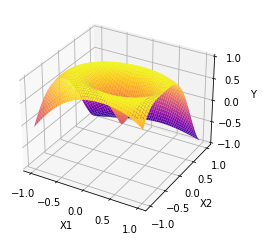

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

## Building 2D model

In [7]:
class LocalMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)

#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [8]:
model = LocalMLP(2, 4, 1).to(device)

In [9]:
model

LocalMLP(
  (layer0): DistanceTransform_Simple()
  (activ): OneActiv()
  (layer1): Linear(in_features=4, out_features=1, bias=True)
)

In [10]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.9056522250175476
200 Error =  0.10139190405607224
400 Error =  0.06692752242088318
600 Error =  0.048945844173431396
800 Error =  0.03594230115413666
1000 Error =  0.029904205352067947
1200 Error =  0.027880359441041946
1400 Error =  0.0270277988165617
1600 Error =  0.02658504620194435
1800 Error =  0.026283210143446922
2000 Error =  0.026026207953691483
2200 Error =  0.025860147550702095
2400 Error =  0.025718173012137413
2600 Error =  0.025596417486667633
2800 Error =  0.025491219013929367
3000 Error =  0.025398924946784973
3200 Error =  0.025318581610918045
3400 Error =  0.025246817618608475
3600 Error =  0.025181865319609642
3800 Error =  0.025124140083789825
4000 Error =  0.025072060525417328
4200 Error =  0.025024117901921272
4400 Error =  0.02498212456703186
4600 Error =  0.02494247816503048
4800 Error =  0.024906229227781296


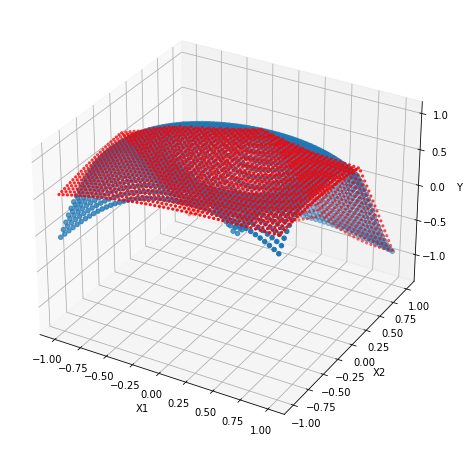

In [12]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [13]:
yout.shape, Y.shape

(torch.Size([2500, 1]), (50, 50))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


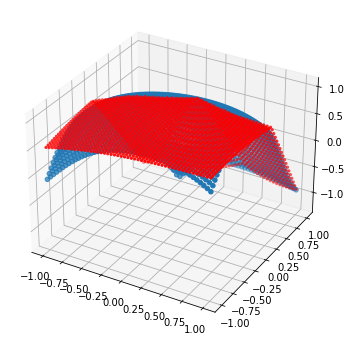

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

In [15]:
"""
DistanceTransform_MinExp creates sharp change in function (undesirable)
"""

'\nDistanceTransform_MinExp creates sharp change in function (undesirable)\n'

## Softmax based similarity 

In [16]:
class LocalMLPsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = nn.LogSoftmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [17]:
model = LocalMLPsoftmax(2, 10, 1)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.6465961933135986
200 Error =  0.03558116778731346
400 Error =  0.019580736756324768
600 Error =  0.008196554146707058
800 Error =  0.002592058153823018
1000 Error =  0.0017611305229365826
1200 Error =  0.0015247472329065204
1400 Error =  0.0013790641678497195
1600 Error =  0.0012913946993649006
1800 Error =  0.0012368267634883523
2000 Error =  0.0011938144452869892
2200 Error =  0.0011442670365795493
2400 Error =  0.0011068711755797267
2600 Error =  0.0010822011390700936
2800 Error =  0.001058297697454691
3000 Error =  0.0010424337815493345
3200 Error =  0.0010282447328791022
3400 Error =  0.0010154987685382366
3600 Error =  0.0010034408187493682
3800 Error =  0.0009902995079755783
4000 Error =  0.0009789110627025366
4200 Error =  0.0009676256449893117
4400 Error =  0.0009570270776748657
4600 Error =  0.0009462331072427332
4800 Error =  0.0009323975536972284


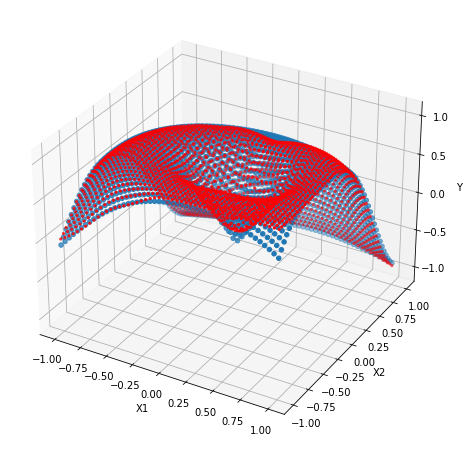

In [19]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [20]:
model.scale_shift.scaler

10

In [21]:
model.scale_shift.shifter

0

In [22]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = F.softmax(xo, dim=-1).data
#     xo = F.log_softmax(xo, dim=-1).data
#     xo = self.activ(xo)
#     xo = self.layer1(xo)
#     return xo
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

In [23]:
forward_intermediate(model, xx)

torch.Size([2500, 10])
tensor([0.0493, 0.0062, 0.2031, 0.0185, 0.0051, 0.0043, 0.3650, 0.0074, 0.0830,
        0.2581]) 
  tensor([0.0895, 0.0122, 0.2681, 0.0752, 0.0097, 0.0210, 0.2546, 0.0165, 0.1672,
        0.3262])
tensor([2.9246e-06, 1.6854e-06, 5.0396e-05, 6.5253e-08, 3.6870e-08, 1.5616e-10,
        7.8596e-03, 1.7922e-08, 2.3388e-06, 1.5043e-03]) 
  tensor([0.3583, 0.0852, 0.9005, 0.7150, 0.0432, 0.2520, 0.8468, 0.0749, 0.9181,
        0.9850])


## Random Initialization with Softmax-10

In [24]:
H = 100
model = LocalMLPsoftmax(2, H, 1)

In [25]:
randidx = torch.randperm(len(xx))[:H]
model.layer0.centers.data = xx[randidx] 
model.layer1.weight.data = yy[randidx].t()

In [26]:
model.layer1.bias.data *= 0.

In [27]:
yout = model(xx)
loss = criterion(yout, yy)
loss

tensor(0.0201, grad_fn=<MseLossBackward>)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


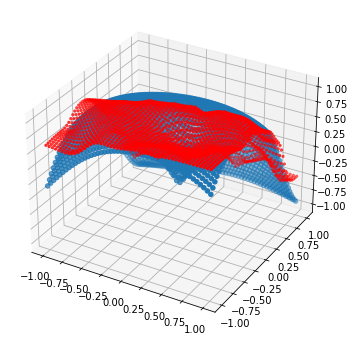

In [28]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

In [29]:
"""
1. Test for 2D classification -> softmax-10 and random init
2. Test e-Softmax (or distance) for activating region of uncertainity (viz decision boundary)
            -> Also try with min-exp
3. Try DT-minExp but with KNN scaled distances (rather than std scaled)
4. Train the function to produce uni-modular activation (using loss function)
5. Train 2D experiments with noisy adding and pruning mechanism (for softmax and updated unimodal neurons) 
"""

'\n1. Test for 2D classification -> softmax-10 and random init\n2. Test e-Softmax (or distance) for activating region of uncertainity (viz decision boundary)\n            -> Also try with min-exp\n3. Try DT-minExp but with KNN scaled distances (rather than std scaled)\n4. Train the function to produce uni-modular activation (using loss function)\n5. Train 2D experiments with noisy adding and pruning mechanism (for softmax and updated unimodal neurons) \n'

## 1. Classification

In [30]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

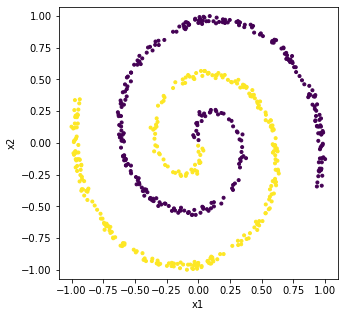

In [31]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [32]:
xx, yy = xx.to(device), yy.to(device)

In [33]:
H = 10
model = LocalMLPsoftmax(2, H, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.69, Loss:0.6504840850830078
Epoch: 199, Acc:0.77, Loss:0.6095420122146606
Epoch: 299, Acc:0.82, Loss:0.5753403902053833
Epoch: 399, Acc:0.84, Loss:0.5470848679542542
Epoch: 499, Acc:0.84, Loss:0.5235971808433533
Epoch: 599, Acc:0.84, Loss:0.5032455325126648
Epoch: 699, Acc:0.85, Loss:0.48349329829216003
Epoch: 799, Acc:0.86, Loss:0.4347781240940094
Epoch: 899, Acc:0.97, Loss:0.3735548257827759
Epoch: 999, Acc:0.99, Loss:0.32928457856178284


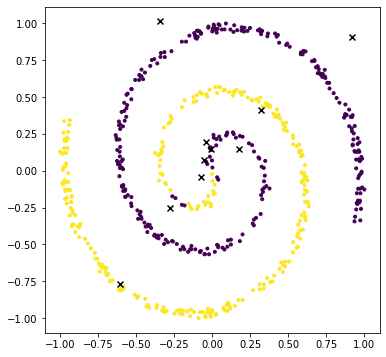

Epoch: 1099, Acc:1.00, Loss:0.29418864846229553
Epoch: 1199, Acc:1.00, Loss:0.26544129848480225
Epoch: 1299, Acc:1.00, Loss:0.24038933217525482
Epoch: 1399, Acc:1.00, Loss:0.22058123350143433
Epoch: 1499, Acc:1.00, Loss:0.2035134732723236
Epoch: 1599, Acc:1.00, Loss:0.18848206102848053
Epoch: 1699, Acc:1.00, Loss:0.1750914305448532
Epoch: 1799, Acc:1.00, Loss:0.16307927668094635
Epoch: 1899, Acc:1.00, Loss:0.15223848819732666
Epoch: 1999, Acc:1.00, Loss:0.14239726960659027


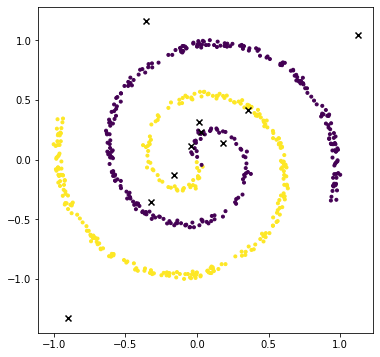

Epoch: 2099, Acc:1.00, Loss:0.13342148065567017
Epoch: 2199, Acc:1.00, Loss:0.12519682943820953
Epoch: 2299, Acc:1.00, Loss:0.11761181801557541
Epoch: 2399, Acc:1.00, Loss:0.11054179072380066
Epoch: 2499, Acc:1.00, Loss:0.1039542481303215
Epoch: 2599, Acc:1.00, Loss:0.09787032753229141
Epoch: 2699, Acc:1.00, Loss:0.09210675209760666
Epoch: 2799, Acc:1.00, Loss:0.08686001598834991
Epoch: 2899, Acc:1.00, Loss:0.08200443536043167
Epoch: 2999, Acc:1.00, Loss:0.07748939096927643


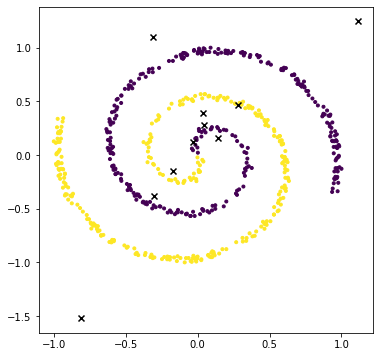

Epoch: 3099, Acc:1.00, Loss:0.07328607887029648
Epoch: 3199, Acc:1.00, Loss:0.06936841458082199
Epoch: 3299, Acc:1.00, Loss:0.06570801883935928
Epoch: 3399, Acc:1.00, Loss:0.06228340044617653
Epoch: 3499, Acc:1.00, Loss:0.05907735228538513
Epoch: 3599, Acc:1.00, Loss:0.05606621876358986
Epoch: 3699, Acc:1.00, Loss:0.053240738809108734
Epoch: 3799, Acc:1.00, Loss:0.0505446121096611
Epoch: 3899, Acc:1.00, Loss:0.04803219065070152
Epoch: 3999, Acc:1.00, Loss:0.045668914914131165


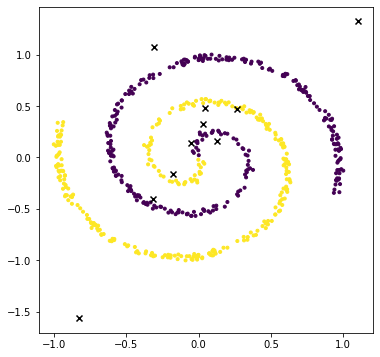

Epoch: 4099, Acc:1.00, Loss:0.04344230890274048
Epoch: 4199, Acc:1.00, Loss:0.04134238511323929
Epoch: 4299, Acc:1.00, Loss:0.03935910388827324
Epoch: 4399, Acc:1.00, Loss:0.03748445585370064
Epoch: 4499, Acc:1.00, Loss:0.0357099212706089
Epoch: 4599, Acc:1.00, Loss:0.03403026610612869
Epoch: 4699, Acc:1.00, Loss:0.03243917599320412
Epoch: 4799, Acc:1.00, Loss:0.030931008979678154
Epoch: 4899, Acc:1.00, Loss:0.0295006912201643
Epoch: 4999, Acc:1.00, Loss:0.028143491595983505


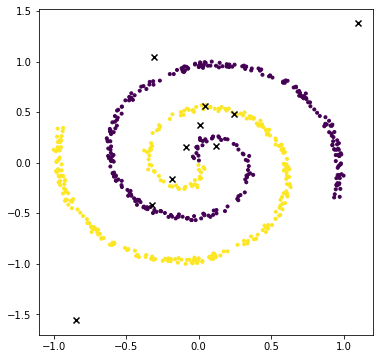

In [34]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

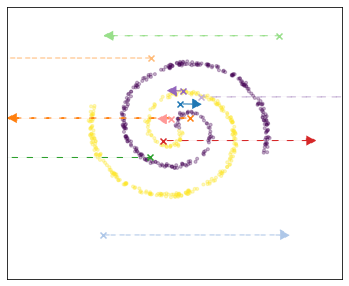

In [35]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

#### Random Init

In [36]:
H = 10
model = LocalMLPsoftmax(2, H, 1)
model

LocalMLPsoftmax(
  (layer0): DistanceTransform_Simple()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
randidx = torch.randperm(len(xx))[:H]

In [38]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
model.layer1.weight.data = (yy[randidx].t()*2-1)*1.0
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.7061477899551392, 0.5916666388511658)

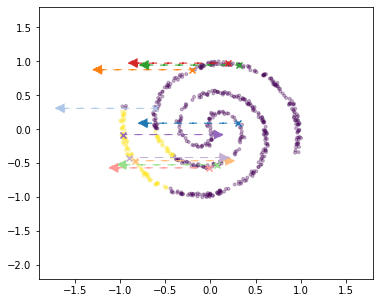

In [39]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [40]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

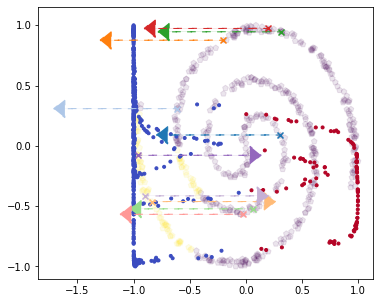

In [41]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

## epsilon-Softmax neuron

In [42]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, dim=-1, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        super().__init__()
        self.dim= dim
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
#         return torch.log_softmax(
        return torch.softmax(
            torch.cat([self.sign*x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=self.dim), 
            dim=self.dim)#[:, :-1]

In [43]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
    
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = EpsilonSoftmax(dim=-1, epsilon=epsilon)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [44]:
H = 10
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=0.3)
model(xx).shape

torch.Size([600, 1])

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.64, Loss:0.6673327684402466
Epoch: 199, Acc:0.75, Loss:0.6258587837219238
Epoch: 299, Acc:0.85, Loss:0.5728284120559692
Epoch: 399, Acc:0.93, Loss:0.5103438496589661
Epoch: 499, Acc:0.94, Loss:0.45528310537338257
Epoch: 599, Acc:0.98, Loss:0.4078446924686432
Epoch: 699, Acc:0.99, Loss:0.36918339133262634
Epoch: 799, Acc:1.00, Loss:0.3371109068393707
Epoch: 899, Acc:1.00, Loss:0.30705273151397705
Epoch: 999, Acc:1.00, Loss:0.28086891770362854


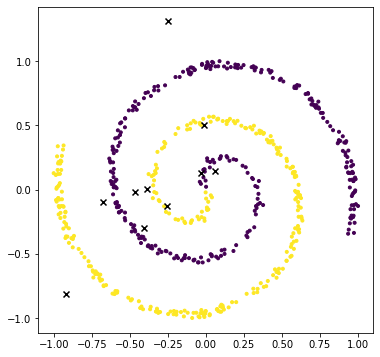

Epoch: 1099, Acc:1.00, Loss:0.2586798071861267
Epoch: 1199, Acc:1.00, Loss:0.23895518481731415
Epoch: 1299, Acc:1.00, Loss:0.22131484746932983
Epoch: 1399, Acc:1.00, Loss:0.20538204908370972
Epoch: 1499, Acc:1.00, Loss:0.19094392657279968
Epoch: 1599, Acc:1.00, Loss:0.17782478034496307
Epoch: 1699, Acc:1.00, Loss:0.16586627066135406
Epoch: 1799, Acc:1.00, Loss:0.15493422746658325
Epoch: 1899, Acc:1.00, Loss:0.14487090706825256
Epoch: 1999, Acc:1.00, Loss:0.1356426179409027


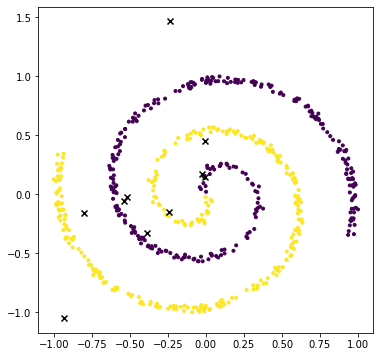

Epoch: 2099, Acc:1.00, Loss:0.12713035941123962
Epoch: 2199, Acc:1.00, Loss:0.1192707046866417
Epoch: 2299, Acc:1.00, Loss:0.11197282373905182
Epoch: 2399, Acc:1.00, Loss:0.1052314043045044
Epoch: 2499, Acc:1.00, Loss:0.09874754399061203
Epoch: 2599, Acc:1.00, Loss:0.09243378043174744
Epoch: 2699, Acc:1.00, Loss:0.0867035910487175
Epoch: 2799, Acc:1.00, Loss:0.08142642676830292
Epoch: 2899, Acc:1.00, Loss:0.07654876261949539
Epoch: 2999, Acc:1.00, Loss:0.07210508733987808


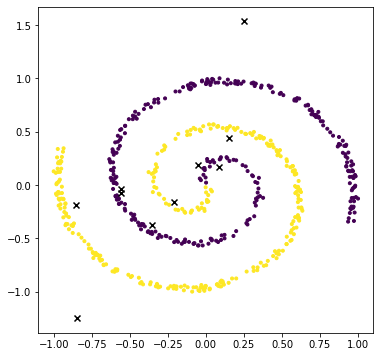

Epoch: 3099, Acc:1.00, Loss:0.06798845529556274
Epoch: 3199, Acc:1.00, Loss:0.06411145627498627
Epoch: 3299, Acc:1.00, Loss:0.06048792973160744
Epoch: 3399, Acc:1.00, Loss:0.05715172365307808
Epoch: 3499, Acc:1.00, Loss:0.054040007293224335
Epoch: 3599, Acc:1.00, Loss:0.05114510655403137
Epoch: 3699, Acc:1.00, Loss:0.0484447181224823
Epoch: 3799, Acc:1.00, Loss:0.04592110961675644
Epoch: 3899, Acc:1.00, Loss:0.04356285557150841
Epoch: 3999, Acc:1.00, Loss:0.04135354235768318


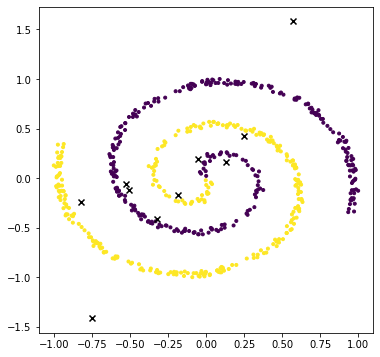

Epoch: 4099, Acc:1.00, Loss:0.03927921876311302
Epoch: 4199, Acc:1.00, Loss:0.03732936456799507
Epoch: 4299, Acc:1.00, Loss:0.03548958897590637
Epoch: 4399, Acc:1.00, Loss:0.03376007080078125
Epoch: 4499, Acc:1.00, Loss:0.032127317041158676
Epoch: 4599, Acc:1.00, Loss:0.0305868498980999
Epoch: 4699, Acc:1.00, Loss:0.029132792726159096
Epoch: 4799, Acc:1.00, Loss:0.027758058160543442
Epoch: 4899, Acc:1.00, Loss:0.026455793529748917
Epoch: 4999, Acc:1.00, Loss:0.025224020704627037


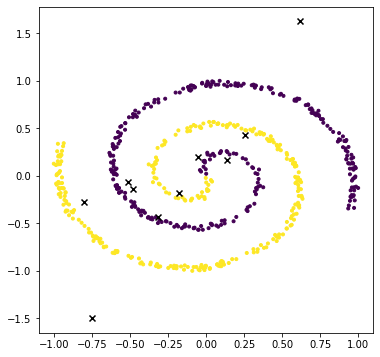

In [46]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

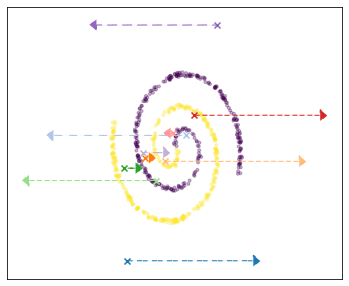

In [47]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

#### Random Init

In [158]:
randidx = torch.randperm(len(xx))[:H]

In [315]:
H = 15
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=0.1)
# model = LocalMLPsoftmax(2, H, 1)
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Simple()
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=16, out_features=1, bias=True)
)

In [316]:
model.scale_shift.scaler = 3

In [317]:
# randidx = torch.randperm(len(xx))[:H]

In [318]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
## For epsilon
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.6690419316291809, 0.5799999833106995)

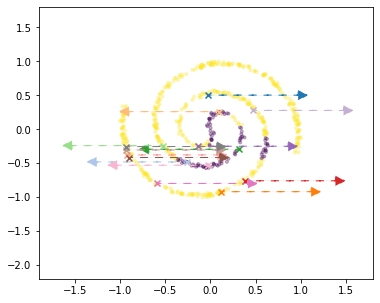

In [319]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [320]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

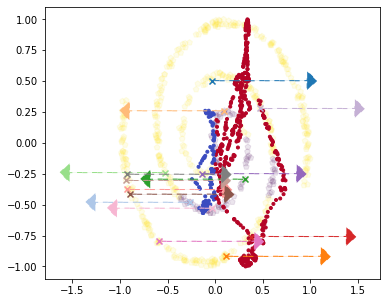

In [321]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [322]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    return xo

In [323]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 16])
tensor([0.1085, 0.0594, 0.0488, 0.1007, 0.0778, 0.0609, 0.0503, 0.0394, 0.0697,
        0.1169, 0.0391, 0.0415, 0.0409, 0.0616, 0.0440, 0.0404]) 
  tensor([0.1267, 0.0464, 0.0790, 0.0826, 0.0727, 0.0534, 0.0695, 0.0493, 0.0436,
        0.1324, 0.0477, 0.0539, 0.0632, 0.0505, 0.0587, 0.0265])
tensor([0.0051, 0.0161, 0.0054, 0.0062, 0.0054, 0.0141, 0.0036, 0.0041, 0.0214,
        0.0023, 0.0041, 0.0042, 0.0042, 0.0143, 0.0045, 0.0127]) 
  tensor([0.4609, 0.2656, 0.3954, 0.3778, 0.3618, 0.2766, 0.4100, 0.2309, 0.2791,
        0.4791, 0.2371, 0.2338, 0.3600, 0.2808, 0.2458, 0.0977])


In [324]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [325]:
YY = forward_intermediate(model, XX)
# YY = YY.reshape(num_points, num_points, H) ## for non-epsilon
YY = YY.reshape(num_points, num_points, H+1) ## for epsilon
YY.shape

torch.Size([1000, 1000, 16])

In [326]:
max_actv = forward_intermediate(model, model.layer0.centers.data.cpu())
# plt.imshow(max_actv)
max_actv = max_actv.diag().numpy()

(1000, 1000)
center: 0.46091616 max_grid: 0.46026462 True


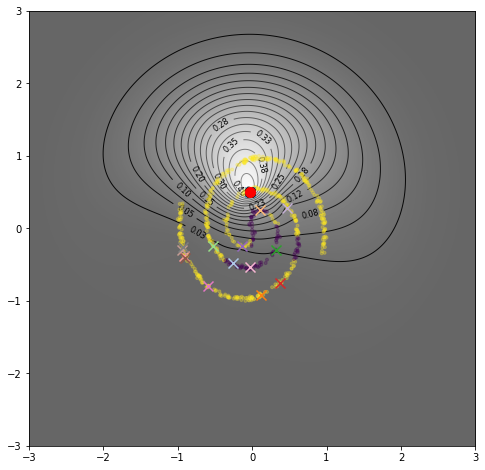

(1000, 1000)
center: 0.26562655 max_grid: 0.26381978 True


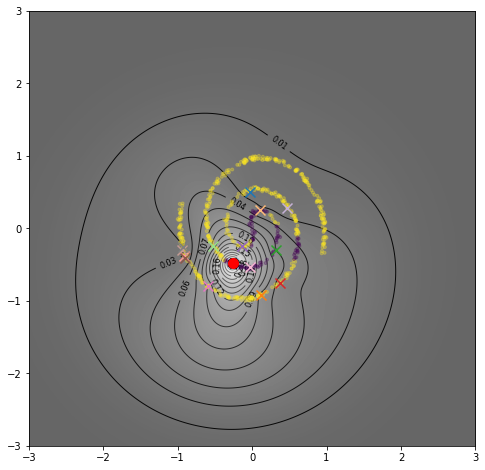

(1000, 1000)
center: 0.39541012 max_grid: 0.39423758 True


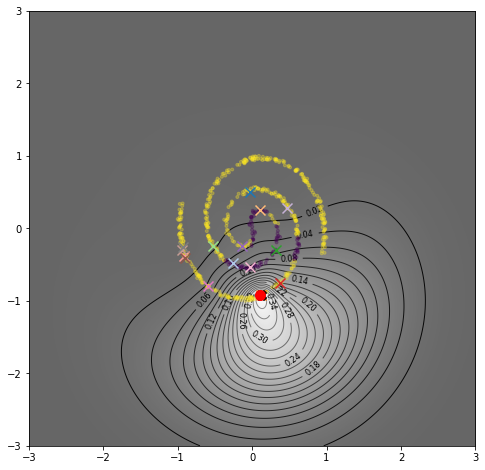

(1000, 1000)
center: 0.37788475 max_grid: 0.3770744 True


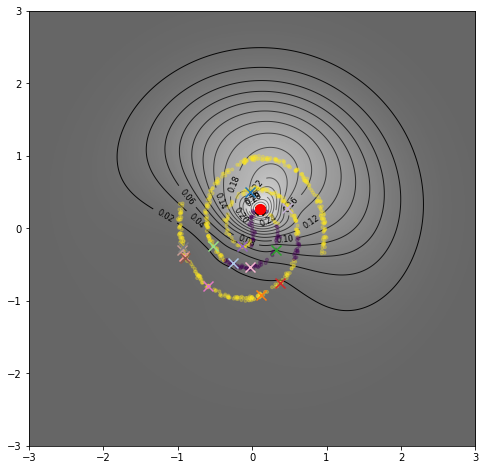

(1000, 1000)
center: 0.36177558 max_grid: 0.36036178 True


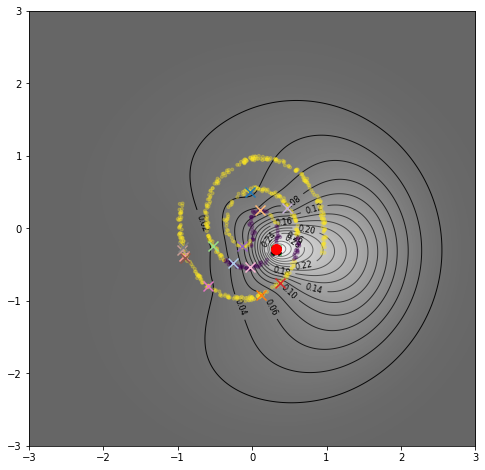

(1000, 1000)
center: 0.276612 max_grid: 0.2750776 True


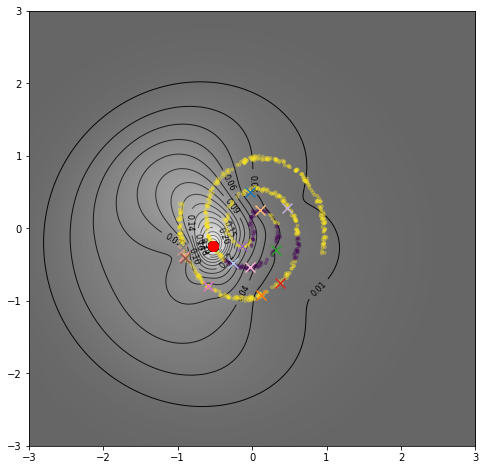

(1000, 1000)
center: 0.4099827 max_grid: 0.40916714 True


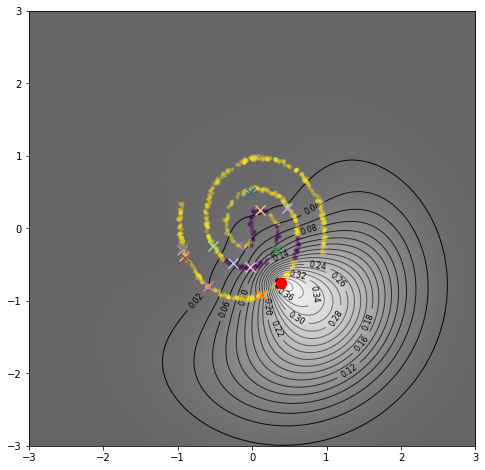

(1000, 1000)
center: 0.23088248 max_grid: 0.22959833 True


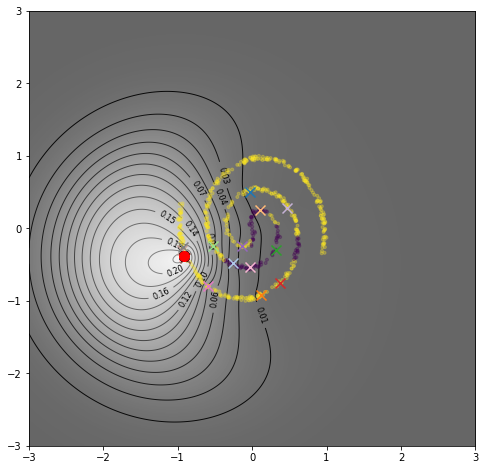

(1000, 1000)
center: 0.27905113 max_grid: 0.27890107 True


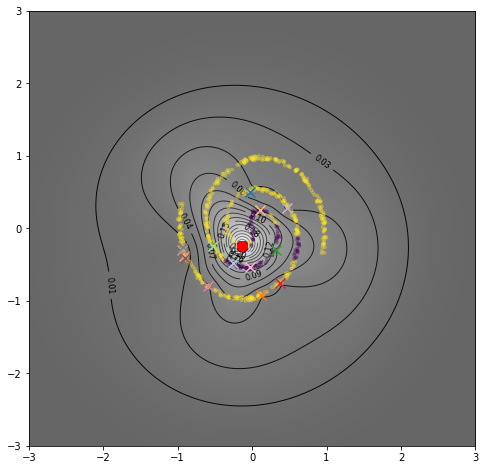

(1000, 1000)
center: 0.47912058 max_grid: 0.47886288 True


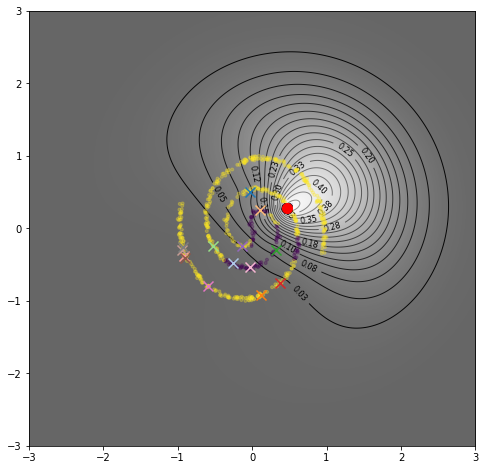

(1000, 1000)
center: 0.23706764 max_grid: 0.2361954 True


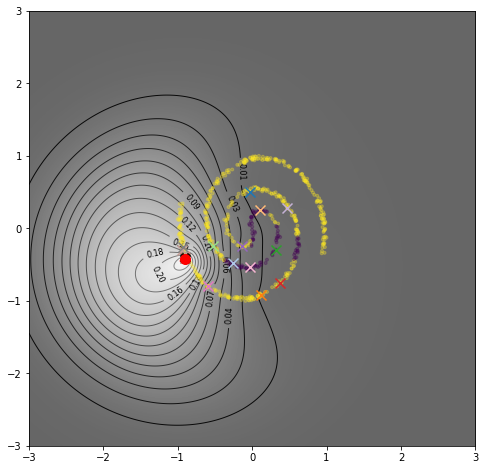

(1000, 1000)
center: 0.23380668 max_grid: 0.23273513 True


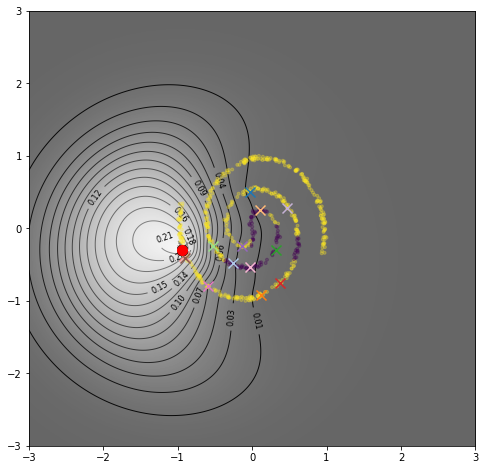

(1000, 1000)
center: 0.36004716 max_grid: 0.35869214 True


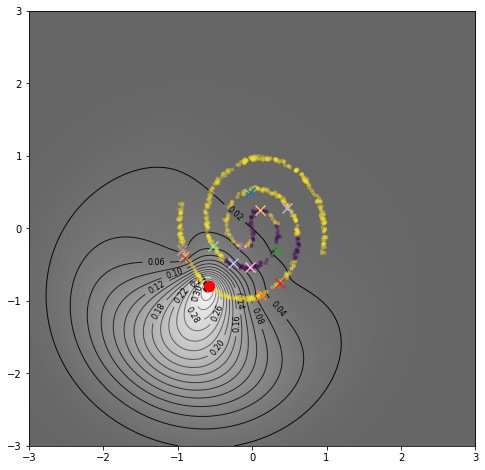

(1000, 1000)
center: 0.28076708 max_grid: 0.27885103 True


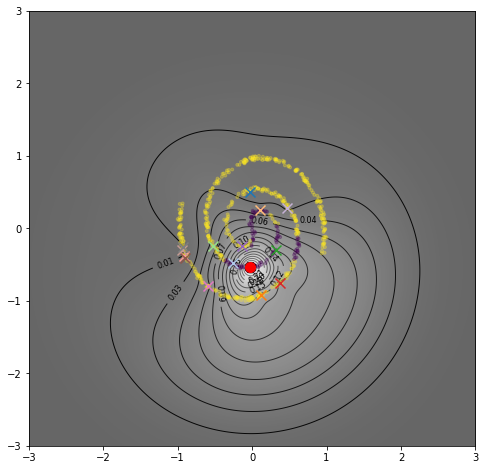

(1000, 1000)
center: 0.24577317 max_grid: 0.24493241 True


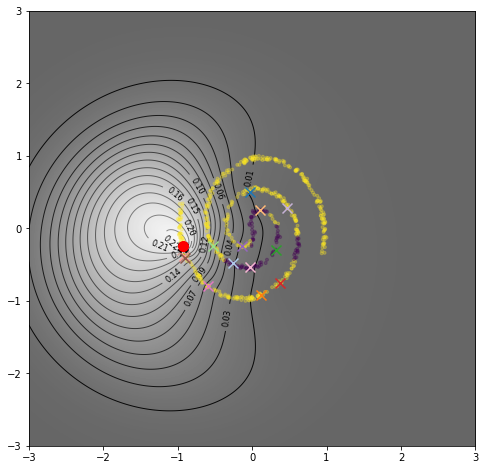

(1000, 1000)


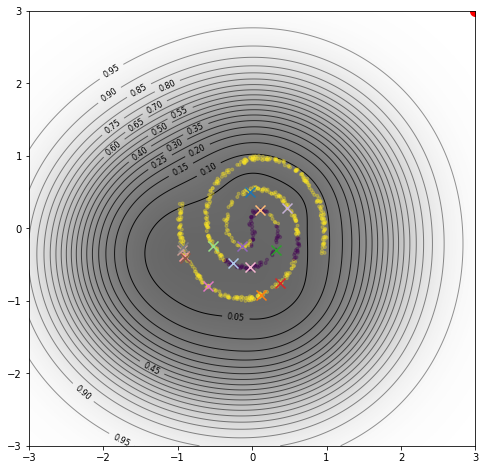

In [327]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,8)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        ## to check difference between DT_gaussian vs DT_simple
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [312]:
model.scale_shift.scaler

10

In [ ]:
# maxpt = np.unravel_index(conf.argmax(), conf.shape)
# maxpt

In [ ]:
# XX[conf.argmax()]

In [ ]:
model

In [ ]:
"""
(All with softmax)
- Distance transform without normalization gives local region of confidence
        - The maximum does not lie at the center
        - Not scaling the distance (gaussian) or scaling-monotonic helps keep the center at maxima
        - epsilon does not lie in between centers (or at the decision boundary) for simple neg-distance
- Distance transform with Normalization gives angular confidence
        - The epsilon also lie around the decision boundary of centers
- Distance transform w/o Norm and d-d_min produces global region..
        - Epsilon lie around db, and are sharp for dtmin
        - for (d-dmin), the maxima and center are same, but extends beyond other centers radially.
        - The maxima still lie at center (but are more like angular confidence) 
        - May use combined with dt-w/o-nrom -> min(d1, d2) to be absolutely sure of decision...
        
- Extend this to iStereoGraphicTransform -> to make it scale well to high dimensions
"""
print()

In [ ]:
"""
for:
dists = torch.exp(-(dists.abs())+self.scaler)
- works well with sqrt scaling or without
- the scaling (/std) keeps desired center minima, and local activation
- the min shift to 0, makes the confidence radial

dists = (1-dists)*torch.exp(self.scaler)
- works similar to exp, but the contours are more tightly packed..

[can combine normalized dist and unnormalized dist to make confidence prediction-> min(C(d_norm), C(d))]
[may take halfway to nearest center as confidence threshold at first]


BIG Question: how to scale to high dim, where the activation is high 
    (eg: most poins lie at dist of 20 in fMNIST)
    1 - dividing by std helps
    2 - cenering to mean hampers the epsilon, works differently
    
    
Try to scale by sigma (to topK value range)    
Try to not use softmax (use dists = cat([epsilon, dists] and use dist-min(dist) to calculate closest ones) 
    - using this with sigma, allows one to predict using max-actv = 1, but sum-actv > 1 for prediction.

"""

In [ ]:
asdasd

In [ ]:
## Best option is to use simple distance transform with softmax-temp

In [ ]:
### Experimentals/NN_Func_Approx/Invertible_Flow_NN/multi_invex_func/03.3_Multi_Invex_MSE_classifier_2D_Iterative_v0(NqW).ipynb

# class LeakySignum(nn.Module):
#     def forward(self, x):
#         o1x = 0.1*x
#         return torch.minimum(torch.maximum(x, o1x), o1x+0.9)
    
# class DistanceMulticlassClassifier(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
        
#         self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
#         self.bias = nn.Parameter(torch.ones(1, num_sets)*-1)
#         self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
# #         init_val = torch.ones(num_sets, output_dim)/output_dim
#         init_val = torch.randn(num_sets, output_dim)*0.1
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 1.
#         self.cls_weight = nn.Parameter(init_val.abs())

#         self.cls_confidence = None
#         self.dist_loss = 0
        
# #         self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
# #         self.actf = LeakyRectFilter()
        
#     def forward(self, x, hard=False):
# #         self.cls_weight.data.abs_()
# #         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
#         x = x[:, :self.input_dim]
#         dists = torch.cdist(x, self.centers)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
# #         dists = dists*self.inv_temp + self.bias
#         dists = dists + self.bias

# #         if hard:
#         dists = self.actf(-dists)
#         indices = torch.argmax(dists, dim=1)
#         c = torch.softmax(self.cls_weight, dim=1)

#         probs = c[indices]
#         scaler = dists[torch.arange(len(indices), dtype=torch.long), indices]
# #         print(scaler)
# #         print(probs)

#         x = torch.softmax(dists, dim=1)
#         y = probs*scaler.reshape(-1, 1)
    
#         self.cls_confidence = scaler.data
# #         self.dist_loss = -torch.cdist(x, self.centers).mean()
# #         return x@c
#         return y

In [ ]:
# H = 20
# model = DistanceMulticlassClassifier(2, H, 2)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()

In [ ]:
# for epoch in range(5000):
#     yout = model(xx)[:, :1]
#     loss = criterion(yout, yy)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1)%l == 0:
#         accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
#         print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

#     if (epoch+1)%1000 == 0:
#         ax = plt.figure(figsize=(6,6)).add_subplot()
#         out = (yout.data.cpu().numpy()>0.5).astype(int)
#         ax.scatter(x1, x2, c=out, marker= '.')
#         ## plot centroids
#         c = model.centers.data.cpu()
#         ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
#         plt.show()

In [ ]:
import inspect

In [ ]:
print(inspect.getsource(dtnn.DistanceTransform_Simple))